In [151]:
import io
import numpy as np
import matplotlib.pyplot as plt
import zarr
import skimage as ski
from PIL import Image

def _select_dataset(root, min_dim_size=1000):
    """ Walk backwards through datasets to find one with 
        the min dimension size in at least one direction.
    """
    multiscale = root['/'].attrs['multiscales'][0]
    selected_dataset = None
    for i in range(len(multiscale['datasets']) - 1, -1, -1):
        dataset_candidate = multiscale['datasets'][i]
        path_candidate = dataset_candidate['path']
        time_series_candidate = root[path_candidate]
        # assumes TCZYX
        image_data_candidate = time_series_candidate[0]
        
        if any(dim >= min_dim_size for dim in image_data_candidate.shape):
            selected_dataset = dataset_candidate
            print(f"Selected dataset at index {i} with shape: {image_data_candidate.shape}")
            break

    if selected_dataset is None:
        # If no dataset has the min dimension size, use the last one as fallback
        selected_dataset = multiscale['datasets'][-1]
        print(f"No dataset with shape >= {min_dim_size} found, using fallback dataset with shape: {root[selected_dataset['path']][0].shape}")

    return selected_dataset


def adjust_brightness(img: np.ndarray, p_lower=0, p_upper=90) -> np.ndarray:
    """ Adjust the brightness of an image by stretching the histogram 
        based on the specified percentiles.
    """
    p_lower, p_upper = np.percentile(img, (p_lower, p_upper))
    print(f"Adjusting brightness from {p_lower} to {p_upper}")
    return ski.exposure.rescale_intensity(img, in_range=(p_lower, p_upper))

    
def stretch_with_max_gain(channel, p_lower=0.1, p_upper=99.9, max_gain=8, target_max=65535):
    """
    Stretch a single image channel to the full range, but limit the maximum gain.

    Parameters
    ----------
    channel : np.ndarray
        2D array for a single channel (e.g., one fluorescence color).
    p_lower : float
        Lower percentile for contrast stretching (default: 0.1).
    p_upper : float
        Upper percentile for contrast stretching (default: 99.9).
    max_gain : float
        Maximum allowed gain (e.g., 8-32). Limits how much a narrow range can be amplified.
    target_max : int
        Target maximum value (65535 for 16-bit output, 255 for 8-bit).

    Returns
    -------
    np.ndarray
        Contrast-stretched channel with gain capped.
    """
    # Convert to float for safe math
    ch_float = channel.astype(np.float32)

    # Compute lower and upper percentiles
    lo = np.percentile(ch_float, p_lower)
    hi = np.percentile(ch_float, p_upper)
    print(f"Lower percentile: {lo}, Upper percentile: {hi}")

    # Calculate the range, ensuring it's not zero
    dynamic_range = max(hi - lo, 1e-6)
    print(f"Dynamic range: {dynamic_range}")

    # Calculate the stretch gain
    gain = target_max / dynamic_range
    print(f"Gain: {gain}")

    if gain>max_gain:
        print(f"Gain is too high, capping at {max_gain}")

    # Cap the gain if it's too high
    gain = min(gain, max_gain)

    # Apply the stretch
    stretched = (ch_float - lo) * gain

    # Clip to the valid range
    stretched = np.clip(stretched, 0, target_max)

    return stretched.astype(np.uint16)


In [153]:
base_path = '/groups/lavis/lavislab/data_external/Dye_Bioavailability_images/Converted_OME-NGFF/'
zarr_path = f'{base_path}/ABC-SiRh_Brain_20240815_Slide_5_from_cassette_1_Region_005_channels.zarr'
zarr_path = f'{base_path}/JF608_Brain_20241001_Slide_2_from_cassette_2_Region_006_channels.zarr'
zarr_path = f'{base_path}/JF632_Brain_20241001_Slide_1_from_cassette_2_Region_006_channels.zarr'
zarr_path = f'{base_path}/SHAM_Brain_20250829_Slide_6_of_1_Region_005_channels.zarr'
zarr_path = f'{base_path}/JF698_Brain_20250829_Slide_8_of_1_Region_003_channels.zarr'
zarr_path = f'{base_path}/FSiRhQ_Brain_20250829_Slide_3_of_2_Region_005_channels.zarr'
store = zarr.DirectoryStore(zarr_path)
root = zarr.open(store, mode='r')

colors = [c['color'] for c in root['/'].attrs['omero']['channels']]
print(colors)

multiscale = root['/'].attrs['multiscales'][0]
print(multiscale)

dataset = _select_dataset(root, min_dim_size=2000)
print(dataset)

path = dataset['path']
time_series = root[path]
image_data = time_series[0] # TCZYX

print(image_data.shape)

# Assuming image_data is of shape (C, Z, Y, X) where C is the number of channels
num_channels = image_data.shape[0]
num_slices = image_data.shape[1]  # This is the Z-axis size
height = image_data.shape[2]      # Y dimension
width = image_data.shape[3]       # X dimension


['0000FF', '00FF00', 'FF8000', 'FF00FF']
{'metadata': {'method': 'loci.common.image.SimpleImageScaler', 'version': 'Bio-Formats 8.3.0'}, 'axes': [{'name': 't', 'type': 'time'}, {'name': 'c', 'type': 'channel'}, {'unit': 'micrometer', 'name': 'z', 'type': 'space'}, {'unit': 'micrometer', 'name': 'y', 'type': 'space'}, {'unit': 'micrometer', 'name': 'x', 'type': 'space'}], 'name': 'Slide 3 of 2_Region 005_channels.tiff', 'datasets': [{'path': '0', 'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0, 0.672062277793884, 0.672062277793884], 'type': 'scale'}]}, {'path': '1', 'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0, 1.344124555587768, 1.344124555587768], 'type': 'scale'}]}, {'path': '2', 'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0, 2.688249111175536, 2.688249111175536], 'type': 'scale'}]}, {'path': '3', 'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0, 5.376498222351072, 5.376498222351072], 'type': 'scale'}]}, {'path': '4', 'coordinateTransformations': [{'sc

Shape of channel_data: (1, 2249, 1284)
Mean: 394.9862160960427, Stddev: 404.1670091488736, Min: 0, Max: 13753
Percentile 90: 826.0
Percentile 95: 1172.0
Percentile 98: 1692.0
Percentile 99: 2057.0
Percentile 99.5: 2388.4249999998137
Percentile 99.9: 3092.0
Percentile 99.99: 3917.2284999997355
Lower percentile: 0.0, Upper percentile: 2388.5
Dynamic range: 2388.5
Gain: 27.43772315979004
Gain is too high, capping at 8


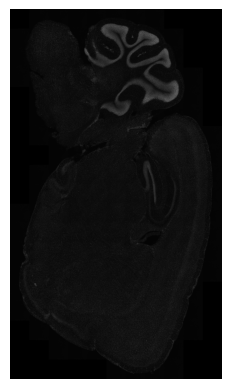

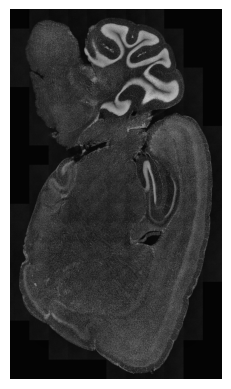

Shape of channel_data: (1, 2249, 1284)
Mean: 500.62164458000717, Stddev: 1497.7529279057237, Min: 0, Max: 65535
Percentile 90: 764.0
Percentile 95: 1849.0
Percentile 98: 4413.0
Percentile 99: 6949.0
Percentile 99.5: 10112.0
Percentile 99.9: 19159.28500000015
Percentile 99.99: 34334.99749999074
Lower percentile: 0.0, Upper percentile: 10112.0
Dynamic range: 10112.0
Gain: 6.4809136390686035


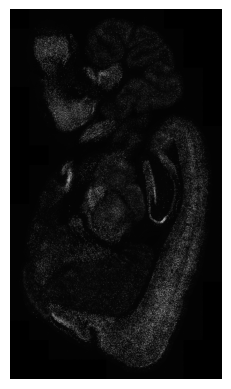

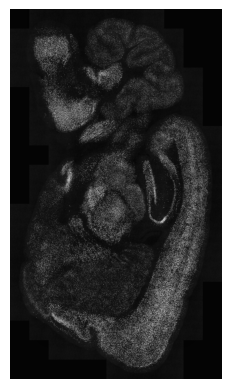

Shape of channel_data: (1, 2249, 1284)
Mean: 583.379441399362, Stddev: 1980.390461103173, Min: 0, Max: 65535
Percentile 90: 905.0
Percentile 95: 2323.0
Percentile 98: 5624.0
Percentile 99: 9031.0
Percentile 99.5: 13199.0
Percentile 99.9: 25584.0
Percentile 99.99: 48156.16949999286
Lower percentile: 0.0, Upper percentile: 13199.0
Dynamic range: 13199.0
Gain: 4.96514892578125


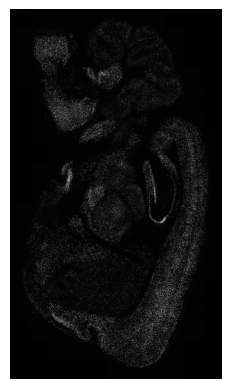

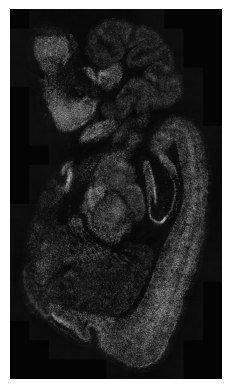

Shape of channel_data: (1, 2249, 1284)
Mean: 142.87967272404904, Stddev: 66.79079283464408, Min: 0, Max: 1179
Percentile 90: 203.0
Percentile 95: 213.0
Percentile 98: 225.0
Percentile 99: 233.0
Percentile 99.5: 240.0
Percentile 99.9: 256.0
Percentile 99.99: 297.0
Lower percentile: 0.0, Upper percentile: 240.0
Dynamic range: 240.0
Gain: 273.0625
Gain is too high, capping at 8


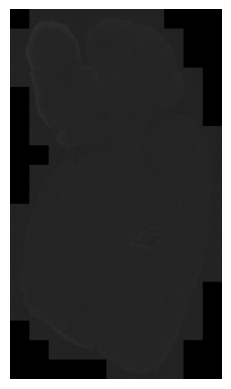

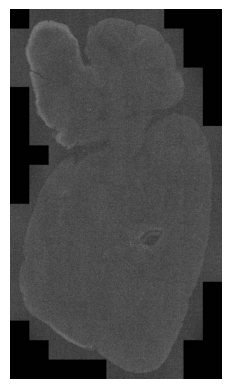

Shape of colored_image: (2249, 1284, 4)
Mean: 0.29060238434179886, Stddev: 0.4213843426966699, Min: 0.0, Max: 1.0
Channel 0 colored with 0000FF


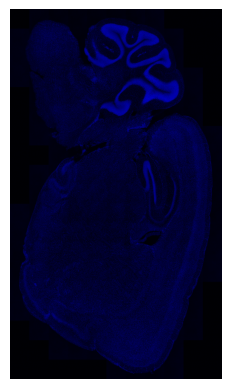

Shape of colored_image: (2249, 1284, 4)
Mean: 0.27915951127288874, Stddev: 0.42523642455950833, Min: 0.0, Max: 1.0
Channel 1 colored with 00FF00


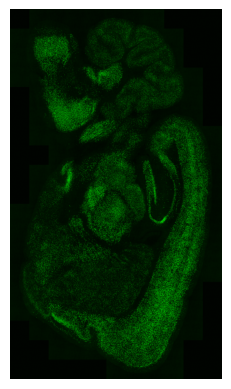

Shape of colored_image: (2249, 1284, 4)
Mean: 0.28899706615195087, Stddev: 0.41999424239881206, Min: 0.0, Max: 1.0
Channel 2 colored with FF8000


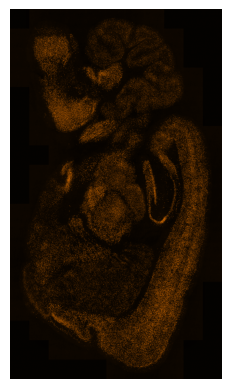

Shape of colored_image: (2249, 1284, 4)
Mean: 0.3751509904876588, Stddev: 0.38964669360981335, Min: 0.0, Max: 1.0
Channel 3 colored with FF00FF


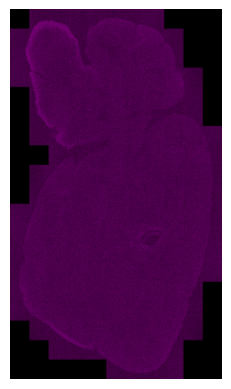

Shape of mip: (770, 439, 4)
Mean: 106.09684865248647, Stddev: 91.5309196208793, Min: 2, Max: 255
Percentile 50: 79.0
Percentile 75: 234.75
Percentile 80: 255.0
Percentile 90: 255.0
Percentile 95: 255.0
Percentile 98: 255.0
Percentile 99: 255.0


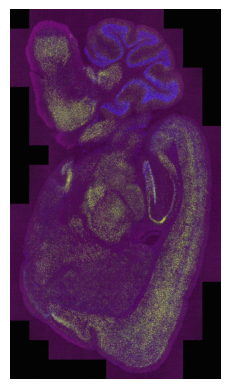

In [156]:
from microfilm import colorify

# Create MIP for each channel
mip_image_list = []
for c in range(num_channels):
    channel_data = image_data[c, :, :, :]  # Extract the data for channel c

    # Sometimes the image is all black because the dynamic range is too low.
    # Let's stretch the contrast for display.
    
    print(f"Shape of channel_data: {channel_data.shape}")
    print(f"Mean: {channel_data.mean()}, Stddev: {channel_data.std()}, Min: {channel_data.min()}, Max: {channel_data.max()}")
    percentiles = [90, 95, 98, 99, 99.5, 99.9, 99.99]
    percentile_values = np.percentile(channel_data, percentiles)
    for p, val in zip(percentiles, percentile_values):
        print(f"Percentile {p}: {val}")

    mip_image = np.max(channel_data, axis=0)  # Perform the MIP across Z-axis

    #mip_image = adjust_brightness(mip_image, 0.1, 99.9)
    mip_image = stretch_with_max_gain(mip_image, 0.1, 99.5)

    plt.imshow(mip_image, cmap='gray')
    plt.axis('off')
    plt.show()

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # skimage expects float images in [0, 1] for CLAHE
    from skimage import exposure
    mip_image = exposure.equalize_adapthist(mip_image, clip_limit=0.02)

    plt.imshow(mip_image, cmap='gray')
    plt.axis('off')
    plt.show()

    mip_image_list.append(mip_image)



# Use colorify_by_hex to create colored versions of each channel
colored_images = []
for i, mip_image in enumerate(mip_image_list):
    # Get the color for this channel, cycling through available colors
    color_hex = colors[i % len(colors)]

    # Colorify the image using the hex color
    colored_image, _, _ = colorify.colorify_by_hex(mip_image, cmap_hex='#'+color_hex)

    print(f"Shape of colored_image: {colored_image.shape}")
    print(f"Mean: {colored_image.mean()}, Stddev: {colored_image.std()}, Min: {colored_image.min()}, Max: {colored_image.max()}")

    #colored_image = adjust_brightness(colored_image, 10, 74)
    #colored_image = exposure.equalize_adapthist(colored_image, clip_limit=0.01)
    #colored_image = adjust_brightness3(colored_image)
    colored_images.append(colored_image)
    print(f"Channel {i} colored with {color_hex}")

    plt.imshow(colored_image)
    plt.axis('off')
    plt.show()

# Combine all colored images into a single multi-color image
if len(colored_images) == 1:
    combined_image = colored_images[0]
else:
    combined_image = colorify.combine_image(colored_images)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(combined_image)
ax.axis('off')

# We need to jump through some hoops to save the figure to a buffer
# in memory (instead of a file) and convert it to a numpy array,
# so that it can be processed further (e.g. for brightness adjustment).
buf = io.BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
plt.close(fig)  # Close the figure to free up memory
buf.seek(0)
with Image.open(buf) as img:
    mip = np.array(img)

#adjusted = adjust_brightness(mip, 30, 80)
#adjusted = exposure.equalize_adapthist(mip, clip_limit=0.03)


print(f"Shape of mip: {mip.shape}")
print(f"Mean: {mip.mean()}, Stddev: {mip.std()}, Min: {mip.min()}, Max: {mip.max()}")
percentiles = [50, 75, 80, 90, 95, 98, 99]
percentile_values = np.percentile(mip, percentiles)
for p, val in zip(percentiles, percentile_values):
    print(f"Percentile {p}: {val}")

adjusted = mip
plt.imshow(adjusted)
plt.axis('off')
plt.show()